In [1]:
import projetLib as proj
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Subset
import torchvision
from tqdm import tqdm
import sys

In [2]:
size = (224,224)
dataset = proj.data.allImageDataset(size) # ,["msdos"]
dataloader = DataLoader(dataset, num_workers=2, batch_size=16, shuffle=True)

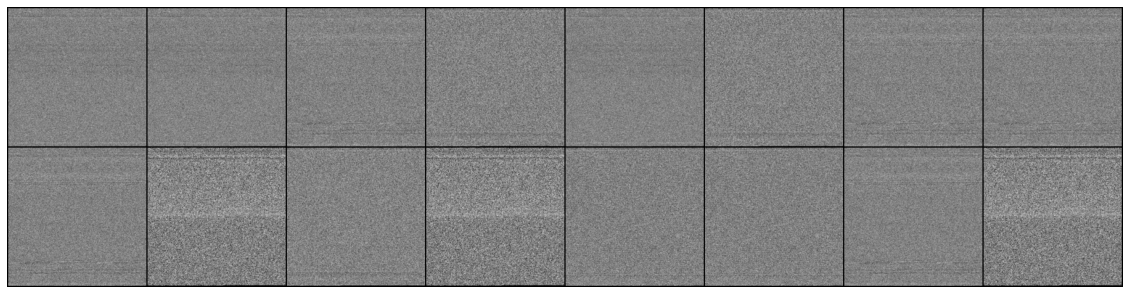

In [3]:
x,_  = next(iter(dataloader)) # On itére en général sur un dataloader avec une boucle pour récupérer des batch (de taille batch_size) mais on peut aussi récupérer seulement le premier batch comme ici
proj.utils.plot_img(x) # Affichage du premier batch

In [4]:
print(x.shape)

torch.Size([16, 1, 224, 224])


In [5]:
def train_malware(net, optimizer, loader, losses, runName="default", epochs=5, lrDecrease=True):
    net.train()
    accum_iter = 100 
    lrs = []
    current_lr = optimizer.param_groups[0]["lr"]
    lambda1 = lambda epoch: 0.67 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    
    t1 = tqdm(range(epochs), total=epochs, desc=f"Training progress", colour="#00ff00", leave=True, file=sys.stdout)    
    for epoch in t1:
        running_loss = []
        t2 = tqdm(loader, leave=False, colour="#005500", file=sys.stdout) 
        for batch_idx,(x,_) in enumerate(t2):
            x = x.to(device)
            with torch.set_grad_enabled(True):
                outputs = net(x)
                loss = 1e-5
                for criterion,coef in losses : 
                    loss += criterion(outputs, x)*coef
                loss /= accum_iter
                running_loss.append(loss.item())
                loss.backward()
                if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(t2)):
                    optimizer.step()
                    optimizer.zero_grad()
                t2.set_description(f'Epoch {epoch}, training loss: {mean(running_loss)}, LR : {current_lr}, epoch {epoch + 1}/{epochs}')
        t1.set_description(f'Epoch {epoch + 1}/{epochs}, LR : {current_lr}')

        if lrDecrease :        
            current_lr = optimizer.param_groups[0]["lr"]
            lrs.append(current_lr)
            scheduler.step()
        torch.save(net.state_dict(),"./modelSave/{}_{}".format(runName,epoch))

In [6]:
batch_size = 32
runName = "first"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = proj.model.GrayscaleResNet(torchvision.models.resnet.Bottleneck,[3, 4, 6, 3])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)

# tuples de loss et leur coef
losses = [#(imp.loss.perceptualVGG,1),
          #(imp.loss.totalVariation,1),
          (torch.nn.L1Loss(),1)]

train_malware(model, optimizer, dataloader, losses, runName=runName, epochs=15)

Training progress:   0%|                                 | 0/15 [01:02<?, ?it/s]

/home/thomas/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([16, 1, 224, 224])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)



KeyboardInterrupt

